In [724]:
#imports


import wfdb
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import os
import pandas as pd
from scipy.signal import butter, filtfilt
from biosppy.signals import ecg
from biosppy.signals import ppg
from biosppy.plotting import plot_ecg
from biosppy.plotting import plot_ppg

In [725]:
#limpiar carpeta de archivos
def limpiar_carpeta(carpeta):
    for file in os.listdir(carpeta):
        os.remove(carpeta+'/'+file)
limpiar_carpeta('data/dirty')
limpiar_carpeta('data/cleaned')

In [726]:
# Obtención de data en los archivos


def get_name_files(path,type):
    files = []
    for file in os.listdir(path):
        if file.endswith(type):
            files.append(file[:-4])
    return files

def read_file_hea(filename, path):
    # lee archivo .hea
    record = wfdb.rdheader(path+filename)
    return record

def read_file_mat(file, path):
    # carga archivo .mat (tiene las señales)
    mat_data = loadmat(path + file +'.mat')
    signals = mat_data['val']
    return signals

def read_file_flat(file,path):
    mat_data = loadmat(path + file +'.mat')
    if 'flatareas' in mat_data:
        flatareas = mat_data['flatareas']
    else:
        flatareas = np.array([])
    return flatareas

def read_file_zigzag(file,path):
    mat_data = loadmat(path + file +'.mat')
    if 'zigzagareas' in mat_data:
        zigzagareas = mat_data['zigzagareas']
    else:
        zigzagareas = np.array([])
    return zigzagareas

---

In [727]:
#Observación de metadata


# path de los archivos iniciales
old_path='data/training/'
#toma los nombres de los archivos .hea
nameFiles = get_name_files(old_path,'.hea')
#revisa el primer archivo .hea
heaRecord1 = read_file_hea(nameFiles[0], old_path)
print(heaRecord1.__dict__)

{'record_name': 'a103l', 'n_sig': 3, 'fs': 250, 'counter_freq': None, 'base_counter': None, 'sig_len': 82500, 'base_time': None, 'base_date': None, 'comments': ['Asystole', 'False alarm'], 'sig_name': ['II', 'V', 'PLETH'], 'p_signal': None, 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['a103l.mat', 'a103l.mat', 'a103l.mat'], 'fmt': ['16', '16', '16'], 'samps_per_frame': [1, 1, 1], 'skew': [None, None, None], 'byte_offset': [24, 24, 24], 'adc_gain': [7247.0, 10520.0, 12530.0], 'baseline': [0, 0, 0], 'units': ['mV', 'mV', 'NU'], 'adc_res': [16, 16, 16], 'adc_zero': [0, 0, 0], 'init_value': [-171, 9127, 6042], 'checksum': [-27403, -301, -17391], 'block_size': [0, 0, 0]}


In [728]:
all_unique_sig_names = set()
for file in nameFiles:
    record = read_file_hea(file, old_path)
    all_unique_sig_names.update(record.sig_name)

print(f"All unique signal names across all files: {all_unique_sig_names}")
print(f"Total number of unique signal names: {len(all_unique_sig_names)}")

All unique signal names across all files: {'ABP', 'PLETH', 'MCL', 'II', 'V', 'aVR', 'III', 'I', 'aVF', 'aVL', 'RESP'}
Total number of unique signal names: 11


In [729]:
# contar cuantos datos .mat hay en data/training
i=0
for file in os.listdir('data/training/'):
    if file.endswith('.mat'):
        i += 1
print('cantidad de datos:', i)

cantidad de datos: 750


---
# Limpiar marcas de línea plana, zigzag y ruido

Si una señal tiene muchas marcas planas o zigzag, se deben tomar medidas:
- Si está en training, no se debe usar.
- Si esta en test, no se dispara ninguna alarma. y se etiqueta de alguna forma.


In [730]:
# funciones antiguas


def mark_flat_lines(signal, fs=250, min_duration=0.3, flat_value=-9999, threshold=7):
    """
    Marca líneas planas en la señal donde la diferencia entre valores consecutivos es menor que un umbral.

    Parameters:
    - signal: La señal a analizar (ECG o PPG).
    - fs: Frecuencia de muestreo en Hz.
    - min_duration: Duración mínima en segundos para que se considere una línea plana.
    - flat_value: El valor que se utilizará para marcar las líneas planas en la señal.
    - threshold: Umbral de diferencia entre muestras consecutivas para considerar una línea plana.
    
    Returns:
    - marked_signal: La señal con las líneas planas marcadas.
    - flat_areas: Lista de tuplas (inicio, fin) que indican las áreas planas detectadas.
    """
    # Número de muestras consecutivas que definen una línea plana
    min_samples = int(min_duration * fs)

    # Diferencias absolutas entre muestras consecutivas
    diff_signal = np.abs(np.diff(signal))

    # Encuentra dónde la diferencia es menor que el umbral
    flat_segments = (diff_signal < threshold).astype(int)

    # Identifica segmentos planos continuos de al menos min_samples de duración
    flat_areas = []
    current_length = 0
    start_index = None

    for i in range(len(flat_segments)):
        if flat_segments[i] == 1:  # Si es un segmento plano
            if current_length == 0:
                start_index = i
            current_length += 1
        else:
            if current_length >= min_samples:  # Si cumple con la duración mínima
                flat_areas.append((start_index, start_index + current_length))
            current_length = 0

    # Considerar el último segmento si termina en una zona plana
    if current_length >= min_samples:
        flat_areas.append((start_index, start_index + current_length))

    # Marca los segmentos planos en la señal
    marked_signal = np.copy(signal)
    for start, end in flat_areas:
        marked_signal[start:end] = flat_value  # Marcar con un valor específico como -9999
    
    return marked_signal, flat_areas

def mark_zigzag_lines(signal, fs=250, min_duration=0.3):
    """
    Identifica segmentos en zigzag en una señal.
    
    Parámetros:
    signal (numpy array): La señal a analizar.
    fs (int): Frecuencia de muestreo en Hz. Por defecto es 250 Hz.
    min_duration (float): Duración mínima en segundos de un zigzag. Por defecto es 0.2 segundos.
    
    Retorna:
    zigzag_areas (list): Lista de tuplas (inicio, fin) de los segmentos en zigzag.
    """
    # Número de muestras consecutivas que definen un zigzag
    min_samples = int(min_duration * fs)
    
    # Calcula las diferencias entre muestras consecutivas (pendiente)
    diff_signal = np.diff(signal)
    
    # Determina si la pendiente es positiva o negativa
    sign_changes = np.sign(diff_signal)
    
    # Identifica los cambios de signo consecutivos (zigzag)
    zigzag_segments = (sign_changes[:-1] * sign_changes[1:] == -1).astype(int)

    # Identifica segmentos zigzag continuos de al menos min_samples de duración
    zigzag_areas = []
    current_length = 0
    start_index = None
    
    for i in range(len(zigzag_segments)):
        if zigzag_segments[i] == 1:  # Cambio de pendiente
            if current_length == 0:
                start_index = i
            current_length += 1
        else:
            if current_length >= min_samples:
                zigzag_areas.append((start_index, start_index + current_length + 1))
            current_length = 0

    # Último segmento
    if current_length >= min_samples:
        zigzag_areas.append((start_index, start_index + current_length + 1))
    
    return zigzag_areas

# filtro butterworth
def butter_bandpass_filter(data, cutoff=1, fs=250, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


# filtro bandpass 2
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(ecg_signal, lowcut=0.5, highcut=50.0, fs=250, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered_signal = filtfilt(b, a, ecg_signal)
    return filtered_signal


---

# Selección de datos limpios

In [731]:

new_path = 'data/cleaned/'
dirty_path = 'data/dirty/'

if not os.path.exists(new_path):
    os.makedirs(new_path)
    
#se separan las señales calificadas y las no calificadas
for fileName in nameFiles:
    path = old_path
    record = read_file_hea(fileName, path)
    signals = read_file_mat(fileName, path)

    # Recorta y deja sólo los últimos 10 segundos de señal
    signals = signals[:, -record.fs*20:]
    dirtySignals = signals

    # Se aplica filtro sólo a las señales ECG ('I', 'II', 'III' y 'V') y PLETH
    ecg_type = ['I', 'II', 'III', 'V']
    pleth_type = ['PLETH']
    flat_areas_all = []
    zigzag_areas_all = []

    try:
        for i in range(len(record.sig_name)): 
            
            if record.sig_name[i] in ecg_type:
                flat_signal, flat_areas0 = mark_flat_lines(signals[i, :], fs=record.fs)
                zigzag_areas0 = mark_zigzag_lines(signals[i, :], fs=record.fs)
                flat_areas_all.append(flat_areas0)
                zigzag_areas_all.append(zigzag_areas0)
                # channel = signals[i, :]
                # channel = ecg.ecg(signal=channel, sampling_rate=250, show=False)
                # signals[i, :] = 

            elif record.sig_name[i] in pleth_type:
                flat_signal, flat_areas0 = mark_flat_lines(signals[i, :], fs=record.fs)
                zigzag_areas0 = mark_zigzag_lines(signals[i, :], fs=record.fs)
                flat_areas_all.append(flat_areas0)
                # zigzag_areas_all.append(zigzag_areas0)
                # channel = signals[i, :]
                # channel = ppg.ppg(signal=channel, sampling_rate=250, show=False)

            else:
                flat_areas_all.append([])
                zigzag_areas_all.append([])

        # si no hay líneas planas ni zigzag en ningun canal, se guarda la señal
        if all(len(flat) == 0 for flat in flat_areas_all) and all(len(zigzag) == 0 for zigzag in zigzag_areas_all):
            # Guarda las señales sucias en un archivo .mat para ver cómo quedaron
            sio.savemat(dirty_path + fileName + '.mat', {'val': dirtySignals})
            # Guarda las señales limpias y las áreas en un archivo .mat
            sio.savemat(new_path + fileName + '.mat', {
            'val': signals,
            })
            print('flat areas:', flat_areas_all)
            print('zigzag areas: ', zigzag_areas_all)
            print('se guardó la señal ', fileName, ' en el directorio cleaned')
        else:
            raise Exception(f'Señal {fileName} contiene línes planas o zigzag'.format(fileName))

    except Exception as e:
        print(f'Señal corrupta {fileName}: {e}')
        print(f'Señal no califica para ser del training {fileName} se descarta todo su archivo')

        
        
# se elimino 'v846s' de forma manual ya que saltó el filtro de líneas planas y zigzag
os.remove('data/cleaned/v846s.mat')



flat areas: [[], [], []]
zigzag areas:  [[], []]
se guardó la señal  a103l  en el directorio cleaned
Señal corrupta a104s: Señal a104s contiene línes planas o zigzag
Señal no califica para ser del training a104s se descarta todo su archivo
Señal corrupta a105l: Señal a105l contiene línes planas o zigzag
Señal no califica para ser del training a105l se descarta todo su archivo
flat areas: [[], [], [], []]
zigzag areas:  [[], [], [], []]
se guardó la señal  a109l  en el directorio cleaned
Señal corrupta a123l: Señal a123l contiene línes planas o zigzag
Señal no califica para ser del training a123l se descarta todo su archivo
Señal corrupta a134s: Señal a134s contiene línes planas o zigzag
Señal no califica para ser del training a134s se descarta todo su archivo
Señal corrupta a142s: Señal a142s contiene línes planas o zigzag
Señal no califica para ser del training a142s se descarta todo su archivo
flat areas: [[], [], [], []]
zigzag areas:  [[], [], []]
se guardó la señal  a145l  en el d

In [732]:
# Se revisa cuántas señales se guardaron en el directorio cleaned
i=0
for file in os.listdir('data/cleaned/'):
    if file.endswith('.mat'):
        i += 1
print('cantidad de datos válidos para training:', i)

cantidad de datos válidos para training: 554


---
 ## Visualizadores de señal

In [733]:

def grafica_ecg(record, signals, path_save,picos_r=None):
    #grafica las señales ecg
    plt.figure(figsize=(12, 6))
    for i in range(len(record.sig_name)):
        plt.subplot(len(record.sig_name), 1, i+1)
        plt.plot(signals[i, :], label=f'Señal: {record.sig_name[i]}')
        if picos_r is not None:
            plt.plot(picos_r, signals[i, picos_r], 'ro', markersize=1)
            #Imprime los picos_r
            print(f'Picos R señal {record.sig_name[i]}: {picos_r}')

        plt.xlabel('Muestras')
        plt.ylabel(record.units[i])
        plt.legend()
    #agregar comentarios
    plt.suptitle(record.comments[0] + ' - ' + record.comments[1])
    # genera jpg
    plt.savefig(path_save + record.record_name + '.jpg')
    plt.close()

#función para graficar una cantidad de señales general y guardar en jpg
def graf_signals(files, path, cant, path_save):
    for fileName in files[:cant]:
        print('Graficando señales de: ', fileName)
        record = read_file_hea(fileName, 'data/training/')
        signals, flat_areas, zigzag_areas = read_file_mat(fileName, path) 
        #picos_r = sio.loadmat(path +file+'.mat')['picos_r']
        grafica_ecg(record,signals, path_save)

# Grafica todos los canales de una señal con sus areas planas y zigzag
def grafica_preview(record, signals, oldSignal, path, flat_areas=[], zigzag_areas=[]):
    oldSignal = oldSignal[:, -record.fs*10:]
    plt.figure(figsize=(12, 6))
    for i in range(signals.shape[0]):
        plt.subplot(signals.shape[0], 1, i + 1)
        plt.plot(signals[i, :], label=f'Señal limpia: {record.sig_name[i]}', color='blue', alpha=0.5)
        plt.plot(oldSignal[i, :], label=f'Señal original: {record.sig_name[i]}', color='red', alpha=0.3)
        # Resaltar visualmente los segmentos planos si existen

        if  flat_areas.size > 0:
            for flat in flat_areas[0,i]:
                plt.axvspan(flat[0], flat[1], color='red', alpha=0.5)

        # Resaltar visualmente los segmentos zigzag si existen
        if zigzag_areas.size > 0:
            for zigzag in zigzag_areas[0,i]:
                plt.axvspan(zigzag[0], zigzag[1], color='yellow', alpha=0.5)
        
        plt.xlabel('Muestras')
        plt.ylabel(record.units[i])
        plt.legend()

    plt.suptitle(record.comments[0] + ' - ' + record.comments[1])
    plt.show()

#Grafica señales de biosppy, limpias y con sus atributos importantes
def grafica_preview_bios(record, signal):
    try:
        ecg_type = ['I', 'II', 'III', 'V']
        pleth_type = ['PLETH']
        for i in range(len(record.sig_name)):
            channel = signal[i, :]
            if record.sig_name[i] in ecg_type:
                ecg.ecg(signal=channel, sampling_rate=250, show=True)
            elif record.sig_name[i] in pleth_type:
                ppg.ppg(signal=channel, sampling_rate=250, show=True)
    except Exception as e:
        print(f'Señal {record.record_name} no válida para esta gráfica: {e}')


In [734]:
# Visualizador general: Grafica toda la información útil de una señal
def visualizador_señales_en_file(nameFile_, path, old_path):
    nameFile = nameFiles.index(nameFile_) #nombre de la muestra
    record = read_file_hea(nameFiles[nameFile], old_path) #buscar . hea siempre será en old_path
    signalPreview = read_file_mat(nameFiles[nameFile], path)
    oldSignal = read_file_mat(nameFiles[nameFile], old_path)
    flat_areas = read_file_flat(nameFiles[nameFile], path)
    zigzag_areas = read_file_zigzag(nameFiles[nameFile], path)

    grafica_preview(record, signalPreview, oldSignal, path, flat_areas, zigzag_areas)
    grafica_preview_bios(record, signalPreview) #sólo para señales correctas
def visualizador_señales_limpias(record, signals):
    ecg_type = ['I', 'II', 'III', 'V']
    pleth_type = ['PLETH']
    print(record.comments[0] + ' - ' + record.comments[1])
    for i in range(len(record.sig_name)):
        print(record.sig_name[i])
        channel = signals[i, :]
        if record.sig_name[i] in ecg_type:
            a=ecg.ecg(signal=channel, sampling_rate=250, show=True)
        elif record.sig_name[i] in pleth_type:
            ppg.ppg(signal=channel, sampling_rate=250, show=True)


Bradycardia - True alarm
II


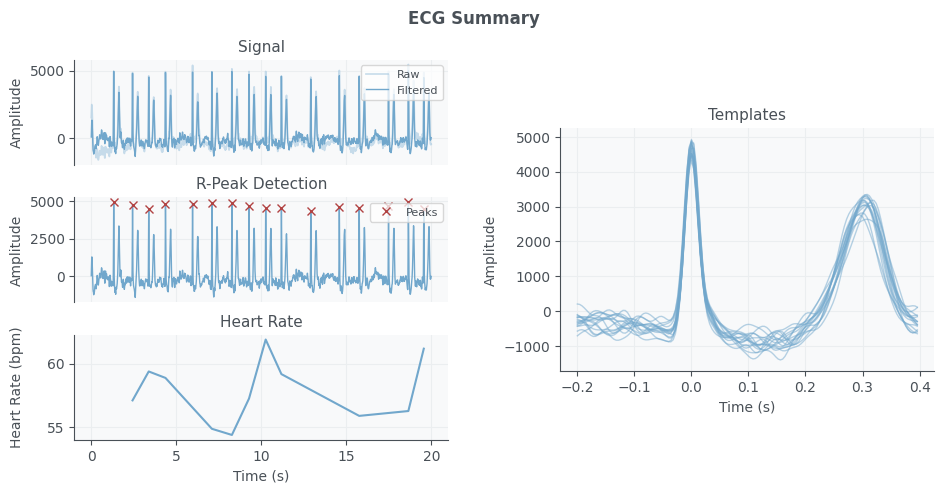

V


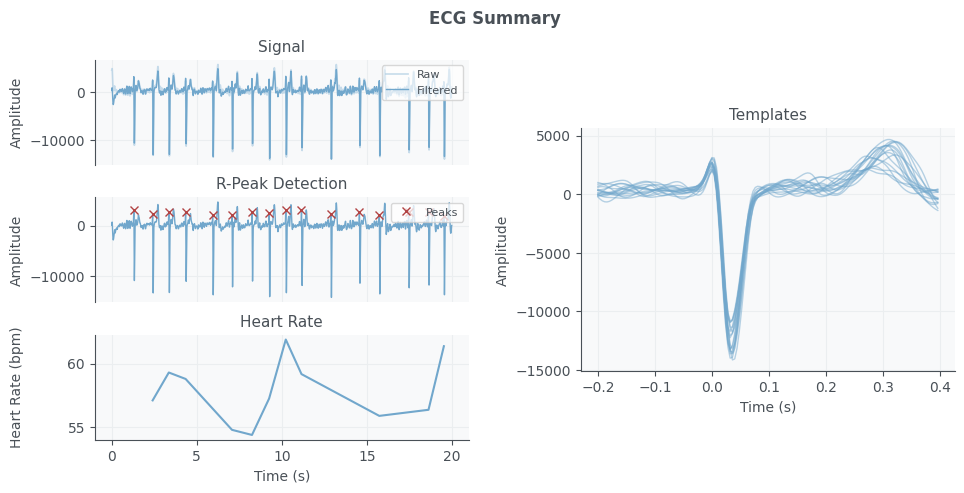

PLETH


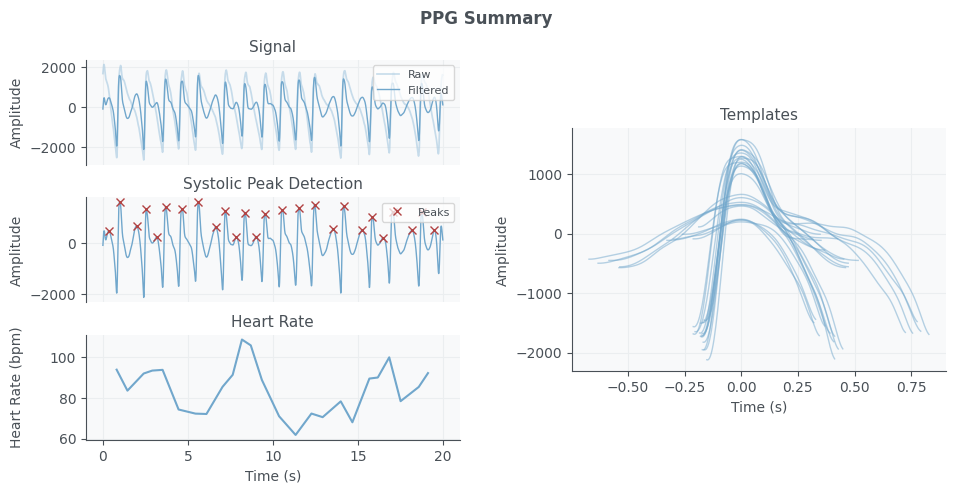

In [735]:
visualizador_señales_limpias(read_file_hea('b124s', 'data/training/'), read_file_mat('b124s', 'data/cleaned/'))

---
# Preparación de los datos calificados

## Tabla de tipos de arritmia

| Tipo de Anomalía | Caracterísitica |
| --- | --- |
| Asistolia | Sin QRS durante al menos 4 segundos |
| Bradicardia extrema | Frecuencia cardíaca inferior a 40 lpm durante 5 latidos consecutivos |
| Taquicardia extrema | Frecuencia cardíaca superior a 140 lpm durante 17 latidos consecutivos |
| Taquicardia ventricular | 5 o más latidos ventriculares con frecuencia cardíaca superior a 100 lpm |
| Aleteo ventricular/Fibrilación | Fibrilatoria, aleteo o forma de onda oscilatoria durante al menos 4 segundos |

biospy keys:

para ecg:
[
 'ts',
 'filtered',
 'rpeaks',
 'templates_ts',
 'templates',
 'heart_rate_ts',
 'heart_rate'
]

para ppg:

['ts', 'filtered', 'peaks', 'templates_ts', 'templates', 'heart_rate_ts', 'heart_rate']

In [ ]:
from scipy.signal import savgol_filter

# retorna los datos necesarios y limpios de cada caso
def biosppy_cases_data(new_path, old_path, nameFiles):

    data_cases = []
    
    for fileName in nameFiles:

        signals = read_file_mat(fileName, new_path)
        record = read_file_hea(fileName, old_path)

        # Se aplica filtro sólo a las señales ECG ('I', 'II', 'III' y 'V') y PLETH
        ecg_type = ['I', 'II', 'III', 'V']
        pleth_type = ['PLETH']
        
        allSignals = []

        filtered_channel = []
        
        channel_type = []
        anomaly_type= record.comments[0]
        alarm_veracity = record.comments[1]

        ts = []
        rpeaks = []
        templates_ts = []
        templates = []
        heart_rate_ts = []
        heart_rate = []

        peaks = []

        min_heart_rate_pleth = None
        max_heart_rate_pleth = None
        min_heart_rate_ecg = None
        max_heart_rate_ecg = None

        for i in range(len(record.sig_name)): 
            ecg_if = (record.sig_name[i] in ecg_type)
            pleth_if = (record.sig_name[i] in pleth_type)
            if ecg_if or pleth_if:
                
                if ecg_if:
                    
                    channel = signals[i, :]
                    butterFilter = butter_bandpass_filter(channel, cutoff=1, fs=250, order=2)
                    channel = channel - butterFilter
                    
                    channel = ecg.ecg(signal=channel, sampling_rate=250, show=False)
                    
                    filtered_channel = channel['filtered']
                    channel_type = record.sig_name[i]

                    ts = channel['ts']
                    rpeaks = channel['rpeaks']
                    templates = channel['templates']
                    heart_rate_ecg = channel['heart_rate']

                    if heart_rate_ecg.any():
                        min_heart_rate_ecg = min(heart_rate_ecg)
                    if heart_rate_ecg.any():
                        max_heart_rate_ecg = max(heart_rate_ecg)


                    #data_cases.append({'fileName':fileName, 'channel_type':channel_type, 'alarm_veracity': alarm_veracity ,'anomaly_type': anomaly_type,'channel':filtered_channel, 'ts':ts, 'rpeaks':rpeaks, 'templates_ts':templates_ts, 'templates':templates, 'heart_rate_ts':heart_rate_ts, 'heart_rate_ecg':heart_rate_ecg, 'min_heart_rate_ecg': min_heart_rate_ecg, 'max_heart_rate_ecg': max_heart_rate_ecg})
                    
                elif pleth_if:
                    #print(f'{record.sig_name[i]} - fileName: {fileName}')
                    channel = signals[i, :]
                    channel = ppg.ppg(signal=channel, sampling_rate=250, show=False)
                    
                    filtered_channel = channel['filtered']
                    channel_type = record.sig_name[i]

                    peaks = channel['peaks']
                    heart_rate_pleth = channel['heart_rate']

                    if heart_rate_pleth.any():
                        min_heart_rate_pleth = min(heart_rate_pleth)
                    if heart_rate_pleth.any():
                        max_heart_rate_pleth= max(heart_rate_pleth)

                    #data_cases.append({'fileName': fileName, 'channel_type': channel_type ,'alarm_veracity': alarm_veracity,'anomaly_type':anomaly_type, 'channel': filtered_channel, 'ts':ts ,'peaks': peaks, 'templates_ts':templates_ts, 'templates':templates, 'heart_rate_ts': heart_rate_ts, 'heart_rate_pleth': heart_rate_pleth, 'min_heart_rate_pleth': min_heart_rate_pleth, 'max_heart_rate_pleth': max_heart_rate_pleth})
                allSignals.append([channel, channel_type])
        data_cases.append({'fileName:': fileName, 'channels': allSignals,'alarm_veracity': alarm_veracity, 'anomaly_type': anomaly_type, 'max_heart_rate_ecg': max_heart_rate_ecg, 'min_heart_rate_ecg': min_heart_rate_ecg, 'max_heart_rate_pleth': max_heart_rate_pleth, 'min_heart_rate_pleth': min_heart_rate_pleth})

    return data_cases


In [737]:

new_path = 'data/cleaned/'
#toma los nombres de los archivos .hea
nameFiles = get_name_files(new_path,'.mat')
#revisa el primer archivo .hea
#heaRecord1 = read_file_hea(nameFiles[0], old_path)
#print(heaRecord1.__dict__)

all_unique_comments_anomaly = set()
for file in nameFiles:
    record = read_file_hea(file, old_path)
    all_unique_comments_anomaly.update(record.comments[0].split())

print(f"All unique signal names across all files: {all_unique_comments_anomaly}")
print(f"Total number of unique signal names: {len(all_unique_comments_anomaly)}")

        

All unique signal names across all files: {'Asystole', 'Ventricular_Flutter_Fib', 'Tachycardia', 'Ventricular_Tachycardia', 'Bradycardia'}
Total number of unique signal names: 5


# Importando data

para ecg

({'fileName':fileName, 'channel_type':channel_type, 'alarm_veracity': alarm_veracity ,'anomaly_type': anomaly_type,'channel':filtered_channel, 'ts':ts, 'rpeaks':rpeaks, 'templates_ts':templates_ts, 'templates':templates, 'heart_rate_ts':heart_rate_ts, 'heart_rate':heart_rate})

para pleth

data_cases.append({'fileName': fileName, 'channel_type': channel_type ,'alarm_veracity': alarm_veracity,'anomaly_type':anomaly_type, 'channel': filtered_channel, 'ts':ts ,'peaks': peaks, 'templates_ts':templates_ts, 'templates':templates, 'heart_rate_ts': heart_rate_ts, 'heart_rate': heart_rate})


In [738]:

data_cases = biosppy_cases_data(new_path, old_path, nameFiles)
data_cases = pd.DataFrame(data_cases)


In [739]:
#obtener la segunda fila de df
data_cases
# #obtener el valor de la columna 'fileName' de la segunda fila
# data_cases.iloc[2]['fileName']


,fileName:,channels,alarm_veracity,anomaly_type,max_heart_rate_ecg,min_heart_rate_ecg,max_heart_rate_pleth,min_heart_rate_pleth
0,a103l,[[([0.00000000e+00 3.99920000e-03 7.99840000e-...,False alarm,Asystole,NaN,NaN,134.906760,90.719427
1,a109l,[],False alarm,Asystole,NaN,NaN,NaN,NaN
2,a145l,[[([0.00000000e+00 3.99920000e-03 7.99840000e-...,False alarm,Asystole,NaN,NaN,162.876852,70.155072
3,a163l,[[([0.00000000e+00 3.99920000e-03 7.99840000e-...,False alarm,Asystole,NaN,NaN,74.927522,70.920324
4,a165l,[[([0.00000000e+00 3.99920000e-03 7.99840000e-...,False alarm,Asystole,NaN,NaN,76.369506,68.401768
...,...,...,...,...,...,...,...,...
549,v842s,[[([0.0000e+00 4.0000e-03 8.0000e-03 ... 1.998...,True alarm,Ventricular_Tachycardia,127.685972,79.104246,NaN,NaN
550,v843l,[[([0.00000000e+00 3.99920000e-03 7.99840000e-...,False alarm,Ventricular_Tachycardia,NaN,NaN,76.056196,72.478331
551,v844s,[],True alarm,Ventricular_Tachycardia,NaN,NaN,NaN,NaN
552,v845l,[],False alarm,Ventricular_Tachycardia,NaN,NaN,NaN,NaN


In [740]:
def visualizador_df_signals(channel):
    ecg_type = ['I', 'II', 'III', 'V']
    pleth_type = ['PLETH']
    print(channel['alarm_veracity'] + ' - ' + channel['anomaly_type'])
    if channel['channel_type'] in ecg_type:
        ecg.ecg(signal=channel['channel'], sampling_rate=250, show=True)
    elif channel['channel_type'] in pleth_type:
        ppg.ppg(signal=channel['channel'], sampling_rate=250, show=True)


# Entrenamiento por cada anomalía

## Bradycardia

Los valores de “min_ebpm” y “min_pbpm”
se utilizaron para formar el vector de características del modelo svm


In [741]:
#extraer datos de bradicardia
brady_cases = pd.DataFrame()

brady_cases = data_cases[data_cases['anomaly_type'] == 'Bradycardia']
brady_cases = brady_cases.reset_index(drop=True)






